In [ ]:
import os
import contextlib

import pickle
import math
import random  

import torch
from torch import nn 
from torch.nn import functional as F  
import torchvision
from torchvision import transforms
 
import numpy as np
import matplotlib.pyplot as plt  
 
%matplotlib inline 
torch.manual_seed(0)

### Exploring Metadata

In [3]:
def unpickle(file): 
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# file_dict = unpickle(r'cifar-10-batches-py/batches.meta')
# label_map = file_dict[ b'label_names']
# label_map

In [5]:


# file_dict = unpickle(r'cifar-10-batches-py/data_batch_1')

# rbg_10k_img = file_dict[b'data'] #shape is (10000, 3072) with 
# target_var = file_dict[b'labels']
 
# assert set(target_var) == set(range(10))
# assert rbg_10k_img.shape == (10000, 3072)

In [6]:
'''
rbg_10k_img: Contains rbg of 10k images of file data_batch_{i}   where i in [1,5]
        
        - Has shape (10000, 3072)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

target_var: is the target variable representing the class of the picture  
        - Has shape (10000, 1)
        - The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck
'''
 
def load_data_cifar10(batch_size, resize=None, shuffle_train = False):
    """Download the CIFAR-10 dataset and then load it into memory."""
    
    trans = [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    # Download and create datasets
    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)

    # Create data loaders
    train_iter = torch.utils.data.DataLoader(
        cifar10_train, batch_size=batch_size, shuffle= shuffle_train, num_workers=2)
    test_iter = torch.utils.data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter

### Checking out a random picture with its associated tag

In [7]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = False)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break


Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])
Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])


In [8]:
np.unique(y_train.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

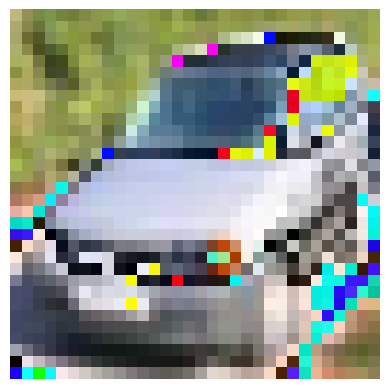

In [9]:
img_no = random.randint(0, 10000)
img_no = 46

# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255 * x_train[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
# print( f'This is a {label_map[int(y_train[img_no])]} ')

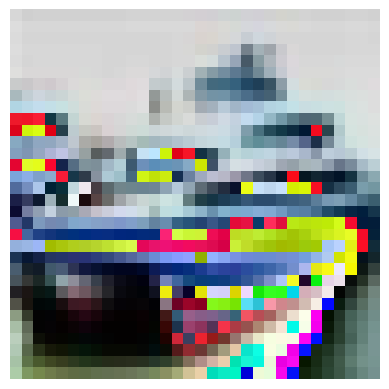

In [10]:
img_no = random.randint(0, 10000)
img_no = 1
# Assuming `rbg_50k_img` is a PyTorch tensor of shape (50000, 3, 32, 32)
img = 255 * x_test[img_no]  # Select first image

# Convert from Tensor to NumPy for plotting
img = img.permute(1, 2, 0).numpy()  # Change shape from (3, 32, 32) -> (32, 32, 3)

# Display the image
plt.imshow(img.astype("uint8"))
plt.axis("off")  # Hide axis
plt.show()
# print( f'This is a {label_map[int(y_test[img_no])]} ')

In [11]:
torch.manual_seed(1)

class InterBlock(nn.Module):
    def __init__(self, device, conv_num_in_channels, num_convolutions, conv_out_channels, conv_kernel_size, conv_stride_val= 1, conv_padding_val=1,  out_block = False):  
        super(InterBlock, self).__init__() 
         
        self.device = device  
        self.out_block = out_block

        self.num_convolutions = num_convolutions
        self.conv_kernel_size = conv_kernel_size
        self.conv_out_channels = conv_out_channels
        self.conv_stride_val = conv_stride_val
        self.conv_padding_val = conv_padding_val
        self.conv_num_in_channels = conv_num_in_channels 
        
        
        self.LConvs = nn.ModuleList([
                            nn.Conv2d(in_channels= conv_num_in_channels, 
                                      out_channels= conv_out_channels,
                                      kernel_size= conv_kernel_size, 
                                      stride= conv_stride_val,
                                      padding= conv_padding_val,
                                      bias= True
                                    ) 
                            for i in range(num_convolutions)
                ]
            ).to(self.device)
        

        self.FCL_a = nn.Linear(in_features= self.conv_num_in_channels,
                               out_features= self.num_convolutions,
                               bias = True
                        ).to(self.device)
        
        self.FCL_out_1 = nn.Linear(in_features= conv_out_channels ,
                                    out_features=128).to(self.device)
        self.FCL_out_2 = nn.Linear(in_features= 128 ,
                                    out_features=10).to(self.device) 

        self.compute_m = nn.AdaptiveAvgPool2d( (1,1) ).to(self.device)  ### Check that this is the same as the mean per channel
        self.Relu = nn.ReLU()
    

    def compute_a(self, x):
        print(f'We will now compute the vector a: [a_1, ..., a_L] ')
        batch_size = x.shape[0]

        #compute m
        m = self.compute_m( x ).reshape([batch_size, self.conv_num_in_channels]) 
        #print(f'm has shape {self.compute_m( x ).shape} and has been transformed to {m.shape} to be inputted in the FCL')
        
        #input m into the FCL
        a = self.FCL_a( m ).to(self.device)                             
        print(f'FCL outputs [a] with shape {a.shape}')

        return a
    
    
    def compute_a_conv_sum(self, a, x):
        #Computing the convolutions
        conv_outputs = []
        for conv in self.LConvs: 
            conv_outputs.append( self.Relu(conv(x)) )  # each output has shape (batch_size, 11, 32, 32)
        # 2. Stack them into a single tensor of shape (batch_size, num_convs, 11, 32, 32)
        #    i.e. we insert a new dimension at dim=1 to hold the "num_convs" dimension.

        conv_outputs_stacked = torch.stack(conv_outputs, dim=1).to(self.device)
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(self.device)
        print(f'a has now has been transformed to {a.shape}. i.e. we insert a new dimension at dim=1 to preserve the "num_convs" dimension.') 
        
        out = (conv_outputs_stacked * a).sum(dim=1) 
        print(f"Weighted convolution output image x' has shape {out.shape}")

        return out


    def compute_out(self, x):
        print('OUTPUT LAYER:')
        batch_size = x.shape[0]
        
        m = self.compute_m( x ).reshape([batch_size, x.shape[1]]).to(self.device)
        print(f'm has shape {self.compute_m( x ).shape} and has been transformed to {m.shape} to be inputted in the FCL') 
        
        out = self.FCL_out_1(m)
        out = self.FCL_out_2(out)

        return out



    def forward(self, x):    
        x = x.to(device) 

        a = self.compute_a(x)

        out = self.compute_a_conv_sum(a, x) 
        out = self.Relu(out)
        #### Same output as above BUT diffrent method  ####
        # out1 = torch.zeros_like(self.Relu(conv(x)))
        # for i, conv in enumerate(self.LConvs): 
        #     conv = self.Relu(conv(x))
        #     out1 +=  a[0][i] * conv  
        # print((out == out1))

        if self.out_block:
            out = self.compute_out(out)

        return out  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = InterBlock( device,
                conv_num_in_channels= 3,
                num_convolutions = 3,
                conv_out_channels = 32,
                conv_kernel_size= 7,
                out_block= False 
            ).to(device)

output = model.forward(x_train)
print(output.shape)
# model

We will now compute the vector a: [a_1, ..., a_L] 
FCL outputs [a] with shape torch.Size([256, 3])
a has now has been transformed to torch.Size([256, 3, 1, 1, 1]). i.e. we insert a new dimension at dim=1 to preserve the "num_convs" dimension.
Weighted convolution output image x' has shape torch.Size([256, 32, 28, 28])
torch.Size([256, 32, 28, 28])


In [12]:
params = { 'num_blocks' : 5,
        'num_convolutions': [3, 3, 3, 3, 3] ,
        'conv_output_layers': [32, 32, 64, 64, 128],
        'conv_kernel_sizes': [7, 5, 7, 5, 5] ,
        'conv_stride_vals': 5*[1],
        'conv_padding_vals': 5*[1]
        }
 

def process_params(params):
    def conv_output_dim(h_in, kernel_size, stride=1, padding=0, dilation=0):
        """
        Returns:
        --------
        int
            The output size (height or width) after the convolution.
        """
        # Apply the standard formula with floor             
        # FIX THISS!!!!!!!!
        return math.floor((h_in + 2*padding - dilation*(kernel_size - 1) - 1) / stride) + 1                 # FIX THISS!!!!!!!!
    

    output_heights = [32]
    for i in range(params['num_blocks'] -1 ):
        kernel_size = params['conv_kernel_sizes'][i]
        stride      = params['conv_stride_vals'][i]
        padding     = params['conv_padding_vals'][i]
        
        h_out = conv_output_dim(output_heights[i-1], kernel_size, stride, padding)
        output_heights.append(h_out)
    params['conv_input_heights'] = output_heights


    conv_input_channels = [3]
    for i in range(params['num_blocks'] -1 ):
        c_in = params['conv_output_layers'][i]
        conv_input_channels.append(c_in)
    params['conv_input_channels'] = conv_input_channels


    return params

process_params(params)

{'num_blocks': 5,
 'num_convolutions': [3, 3, 3, 3, 3],
 'conv_output_layers': [32, 32, 64, 64, 128],
 'conv_kernel_sizes': [7, 5, 7, 5, 5],
 'conv_stride_vals': [1, 1, 1, 1, 1],
 'conv_padding_vals': [1, 1, 1, 1, 1],
 'conv_input_heights': [32, 34, 34, 36, 36],
 'conv_input_channels': [3, 32, 32, 64, 64]}

In [13]:
torch.manual_seed(1)

class CNN(nn.Module):
    '''
    A deep convolutional neural network (CNN) composed of multiple InterBlock modules.
    
    Each InterBlock module contains a set of convolutional layers followed by fully connected layers.
    The network is constructed by stacking a user-specified number of InterBlock modules.
    
    The final block (or the only block when num_blocks == 1) is configured as an output block, which
    processes the feature maps into final predictions (e.g., class scores). Intermediate blocks pass their
    outputs to subsequent blocks without producing final predictions.
    
    Args:
        device (torch.device): CPU or GPU(if available) where computations will be performed.
        num_blocks (int): The total number of InterBlock modules to include in the CNN.
        num_convolutions (list of int): A list where each element specifies the number of convolutional layers 
            to use in the corresponding InterBlock. The length of this list must equal num_blocks.
        num_kernel_sizes (list of int): A list where each element specifies the kernel size for the convolutional 
            layers in the corresponding InterBlock. The length of this list must equal num_blocks. 

    Limitations: 
        - Currently InterBlock's Convolutional layers can only take 1 set of hyperparameters per Block and
          has fixed number of output fully connected layers.
        - The network currently assumes a fixed number of input channels (3) i.e. A batch of RGB images only as inputs.
        - The architecture lacks additional regularization techniques (e.g., dropout, batch normalization) 
          that may be necessary for training deeper networks.
    
    The forward pass applies the InterBlock modules sequentially to the input.
    

    
    
    '''
    def __init__(self, device, num_blocks, conv_nums_in_channels: list, num_convolutions: list, conv_output_layers: list, conv_kernel_sizes: list, conv_stride_vals: list, conv_padding_vals: list):
        super(CNN, self).__init__() 
         
        self.device = device  
        self.num_blocks = num_blocks
        self.num_convolutions = num_convolutions
        self.conv_kernel_sizes = conv_kernel_sizes
        self.conv_output_layers = conv_output_layers
        self.conv_stride_vals = conv_stride_vals
        self.conv_padding_vals = conv_padding_vals
        self.conv_nums_in_channels = conv_nums_in_channels 
        

        assert num_blocks == len(num_convolutions) == len(conv_kernel_sizes) == len(conv_output_layers) == len(conv_stride_vals) == len(conv_padding_vals) == len(conv_padding_vals)
        
        
        if self.num_blocks == 1:
            self.Blocks = nn.ModuleList( [
                                InterBlock(device,
                                    num_convolutions = num_convolutions[0],
                                    conv_num_in_channels = conv_nums_in_channels[0],
                                    conv_out_channels = conv_output_layers[0],
                                    conv_kernel_size= conv_kernel_sizes[0],
                                    conv_stride_val= conv_stride_vals[0],
                                    conv_padding_val= conv_padding_vals[0],
                                    out_block= True)
                            ]
                        )
            
        elif self.num_blocks == 2:
            self.Blocks = nn.ModuleList(
                        [InterBlock(device,
                                    num_convolutions = num_convolutions[0],
                                    conv_num_in_channels = conv_nums_in_channels[0],
                                    conv_out_channels = conv_output_layers[0],
                                    conv_kernel_size= conv_kernel_sizes[0],
                                    conv_stride_val= conv_stride_vals[0],
                                    conv_padding_val= conv_padding_vals[0],
                                    out_block= False)
                                ,
                        InterBlock(device,
                                    num_convolutions = num_convolutions[1],
                                    conv_num_in_channels = conv_nums_in_channels[1],
                                    conv_out_channels = conv_output_layers[1],
                                    conv_kernel_size= conv_kernel_sizes[1],
                                    conv_stride_val= conv_stride_vals[1],
                                    conv_padding_val= conv_padding_vals[1],
                                    out_block= True)
                    ]      
                )

        else: 
            self.Blocks = nn.ModuleList(
                            [InterBlock(device,
                                    num_convolutions = num_convolutions[0],
                                    conv_num_in_channels = conv_nums_in_channels[0],
                                    conv_out_channels = conv_output_layers[0],
                                    conv_kernel_size= conv_kernel_sizes[0],
                                    conv_stride_val= conv_stride_vals[0],
                                    conv_padding_val= conv_padding_vals[0],
                                    out_block= False) 
                                ]
                            )
            for i in range(self.num_blocks - 2):
                print(f'num of channels : {conv_nums_in_channels[i+1]}')
                self.Blocks.extend([
                                InterBlock(device,
                                    num_convolutions = num_convolutions[i+1],
                                    conv_num_in_channels = conv_nums_in_channels[i+1],
                                    conv_out_channels = conv_output_layers[i+1],
                                    conv_kernel_size= conv_kernel_sizes[i+1],
                                    conv_stride_val= conv_stride_vals[i+1],
                                    conv_padding_val= conv_padding_vals[i+1],
                                    out_block= False) 
                                ]
                            )
            self.Blocks.extend([
                                InterBlock(device,
                                    num_convolutions = num_convolutions[num_blocks-1],
                                    conv_num_in_channels = conv_nums_in_channels[num_blocks-1],
                                    conv_out_channels = conv_output_layers[num_blocks-1],
                                    conv_kernel_size= conv_kernel_sizes[num_blocks-1],
                                    conv_stride_val= conv_stride_vals[num_blocks-1],
                                    conv_padding_val= conv_padding_vals[num_blocks-1],
                                    out_block= True)
                            ]    
                        )
    

    def forward(self, x):
        print(f'\nExecuting 1st block with input {x.shape[0]} images of size {x.shape[1:]}')          
        out = self.Blocks[0](x)

        if self.num_blocks > 1:
            for i, block in enumerate(self.Blocks[1:]):
                print(f'\nExecuting block No.{i+2} with input {out.shape[0]} images of size {out.shape[1:]}')
                out = block(out)  

        return  out
     

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

params = { 'num_blocks' : 5,
        'num_convolutions': [4, 3, 3, 3, 3] ,
        'conv_output_layers': [32, 32, 64, 64, 128],
        'conv_kernel_sizes': [7, 5, 7, 5, 5] ,
        'conv_stride_vals': 5*[1],
        'conv_padding_vals': 5*[1]
        }
params = process_params(params)
print(f'Params: {params}')

model = CNN(
            device= device,
            conv_nums_in_channels = params['conv_input_channels'],
            num_blocks= params['num_blocks'],
            num_convolutions= params['num_convolutions'],
            conv_output_layers= params['conv_output_layers'],
            conv_kernel_sizes= params['conv_kernel_sizes'],
            conv_stride_vals= params['conv_stride_vals'],
            conv_padding_vals= params['conv_padding_vals'],  
        ).to(device) 

print(model(x_train).shape)
model

Params: {'num_blocks': 5, 'num_convolutions': [4, 3, 3, 3, 3], 'conv_output_layers': [32, 32, 64, 64, 128], 'conv_kernel_sizes': [7, 5, 7, 5, 5], 'conv_stride_vals': [1, 1, 1, 1, 1], 'conv_padding_vals': [1, 1, 1, 1, 1], 'conv_input_heights': [32, 34, 34, 36, 36], 'conv_input_channels': [3, 32, 32, 64, 64]}
num of channels : 32
num of channels : 32
num of channels : 64

Executing 1st block with input 256 images of size torch.Size([3, 32, 32])
We will now compute the vector a: [a_1, ..., a_L] 
FCL outputs [a] with shape torch.Size([256, 4])
a has now has been transformed to torch.Size([256, 4, 1, 1, 1]). i.e. we insert a new dimension at dim=1 to preserve the "num_convs" dimension.
Weighted convolution output image x' has shape torch.Size([256, 32, 28, 28])

Executing block No.2 with input 256 images of size torch.Size([32, 28, 28])
We will now compute the vector a: [a_1, ..., a_L] 
FCL outputs [a] with shape torch.Size([256, 3])
a has now has been transformed to torch.Size([256, 3, 1, 

CNN(
  (Blocks): ModuleList(
    (0): InterBlock(
      (LConvs): ModuleList(
        (0-3): 4 x Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
      )
      (FCL_a): Linear(in_features=3, out_features=4, bias=True)
      (FCL_out_1): Linear(in_features=32, out_features=128, bias=True)
      (FCL_out_2): Linear(in_features=128, out_features=10, bias=True)
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (Relu): ReLU()
    )
    (1): InterBlock(
      (LConvs): ModuleList(
        (0-2): 3 x Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      )
      (FCL_a): Linear(in_features=32, out_features=3, bias=True)
      (FCL_out_1): Linear(in_features=32, out_features=128, bias=True)
      (FCL_out_2): Linear(in_features=128, out_features=10, bias=True)
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (Relu): ReLU()
    )
    (2): InterBlock(
      (LConvs): ModuleList(
        (0-2): 3 x Conv2d(32, 64, kernel_size=(7, 7), stri

In [14]:
def evaluate_metric(model, data_iter, metric, device):
    """Compute the average `metric` of the model on a dataset.""" 
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    model = model.to(device)
    
    for X, y in data_iter: 
        logits = model(X).to(device)
        c += metric(logits, y.to(device)).to(device)
        n += len(y)  
    return c / n


def correct(logits, y):
    y_hat = logits.argmax(axis=1).to(device) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [15]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = True)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break


Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])
Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])


In [16]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

params = { 'num_blocks' : 5,
        'num_convolutions': [3, 3, 3, 3, 3] ,
        'conv_output_layers': [32, 32, 64, 64, 128],
        'conv_kernel_sizes': [7, 5, 7, 5, 5] ,
        'conv_stride_vals': 5*[1],
        'conv_padding_vals': 5*[1]
        }

num_same_blocks = 3
params = { 'num_blocks' : num_same_blocks,
        'num_convolutions': num_same_blocks*[4] ,
        'conv_output_layers':  [32, 32, 64],
        'conv_kernel_sizes': num_same_blocks*[7] ,
        'conv_stride_vals': num_same_blocks*[1],
        'conv_padding_vals': num_same_blocks*[1]
        }
params = process_params(params)

model = CNN(
            device= device,
            conv_nums_in_channels = params['conv_input_channels'],
            num_blocks= params['num_blocks'],
            num_convolutions= params['num_convolutions'],
            conv_output_layers= params['conv_output_layers'],
            conv_kernel_sizes= params['conv_kernel_sizes'],
            conv_stride_vals= params['conv_stride_vals'],
            conv_padding_vals= params['conv_padding_vals'],  
        ).to(device) 

model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

lr = 0.1
momentum = 0.9
num_epochs = 20

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= momentum)  
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.') 
    
    for x_train, y_train in train_iter: 
        with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                logits = model.forward(x_train).to(device) 
                
        l = cross_entropy_loss(logits , y_train.to(device)).to(device) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them
        
        losses.append(float(l)) # Stores the loss for this batch
       
    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_accs.append( evaluate_metric(model, train_iter , correct, device)  ) 
        test_accs.append( evaluate_metric(model, test_iter, correct, device) ) 
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.')


plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

## THINGS to TRY

1) change kernel size to 3 or 7 or 11
2) change num of convolutions to 3 or 6
3) Add more blocks PROGRAMATICALLY
4) add dropout 
5) 


## CHAMPION MODEL (60% test&train accuracy) SO FAR: 

lr = 0.1
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= momentum)  
num_epochs = 70

InterBlock(
  (LConvs): ModuleList(
    (0-1): 4 x Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (FCL_a): Linear(in_features=3, out_features=2, bias=True)
  (FCL_out_1): Linear(in_features=32, out_features=128, bias=True)
  (FCL_out_2): Linear(in_features=128, out_features=10, bias=True)
  (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
  (Relu): ReLU()
)

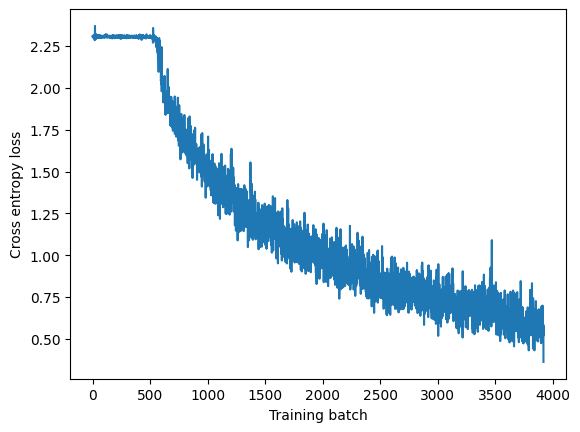

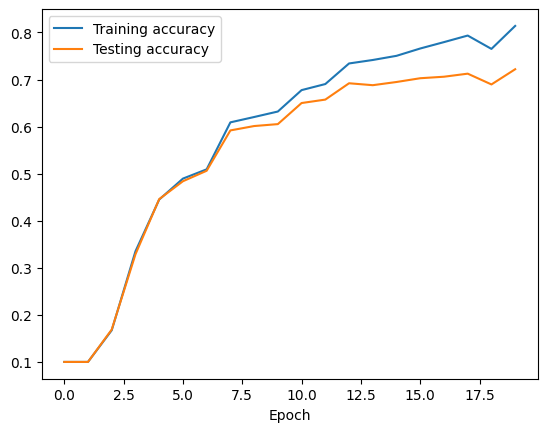

In [ ]:
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()